In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/MLeng/06Unsupervised Machine Learning IBM/Project

/content/drive/MyDrive/Colab Notebooks/MLeng/06Unsupervised Machine Learning IBM


In [ ]:
#Influence of physics paper clustering on published journals using NLP and unsupervised learning
'''
Context and Problem Statement:
- This project was performed to cluster physics papers based on their title and abstract in order to find the right journal for publication with high approval.
- The physics paper dataset was labelled by using clustering algorithms including K-means, Hierarchical agglomerative, Mean shift, and DBSCAN.
- Firstly, the textual data was converted to numerical data by using NLP techniques such as Tokenization, Vectorization, Removing stop words and punctuation, Stemming, and Lemmatization.
- Then, I visualized the most common words by using bar plot, tree plot and word cloud.
- Finally I used dimensionality reduction techniques for visualization.
- using Topic modelling to find the keywords of each cluster >>> to find publications with similar research backgrounds
                                                             >>> to compare similar research and publications

ArXiv dataset: - open access to scholarly articles in scientific fields (physics, mathematics, computer science, quantitative biology, quantitative finance, statistics, electrical engineering and systems science, and economics)
               - operated by Cornell University
               - provides only a metadata file in the json format

Features: - id: ArXiv ID (can be used to access the paper, see below)
          - submitter: Who submitted the paper
          - authors: Authors of the paper
          - title: Title of the paper
          - comments: Additional info, such as number of pages and figures
          - journal-ref: Information about the journal the paper was published in
          - doi: [https://www.doi.org](Digital Object Identifier)
          - abstract: The abstract of the paper
          - categories: Categories / tags in the ArXiv system
          - versions: A version history

Process: 1. Import data
         2. Perform EDA and feature engineering
         3. Text preprocessing using NLP >>> tokenization, remove stop words and punctuation, stemming, lemmatization, and vectorization
         4. Visualization of most common words by bar plot, tree plot and word cloud
         5. Vectorization >>> convert text data into numerical data using TF-IDF matrix
         6. Dimensionality reduction with Non-Negative Matrix Factorization (NMF)
         7. Clustering using K-means
         8. Clustering using Hierarchical agglomerative
         9. Clustering using Mean shift
         10. Clustering using DBSCAN
         11. Visualization using t-SNE
         12. Visualization using UMAP

'''


'\nGoal: - to cluster scientifical papers based on theirs abstract with unsupervised ML methods\n      - perform preprocessing steps >>> stops word removing, handling different languages, different vectorization strategies\n      - using NLP (Natural Language Processing) to prepare the data\n      - using Clustering for labelling\n      - using Dimensionality reduction for visualization (scatter plot)\n      - using Topic modelling to find the keywords of each cluster >>> to find publications with similar research backgrounds\n                                                                   >>> to compare similar research and publications\n\nArXiv dataset: - open access to scholarly articles in scientific fields (physics, mathematics, computer science, quantitative biology, quantitative finance, statistics, electrical engineering and systems science, and economics)\n               - operated by Cornell\n               - provides only a metadata file in the json format\n\nFeatures: - 

In [ ]:
#1. Import data
'''
import logging
logger = logging.getLogger("spacy")
logger.setLevel(logging.ERROR)

import dask.bag as db     #load the dataset with the library dask >>> load large datasets and process them on personal computers or VM's with limited resources
import json
import pandas as pd
docs = db.read_text('arxiv-metadata-oai-snapshot2025.json').map(json.loads)
print(docs.count().compute())      #Total number of documents
print(docs.take(2))                #Looking at one document

#prototyping with a subset of the data
get_latest_version = lambda x: x['versions'][-1]['created']
trim = lambda x: {'id': x['id'],                                #get only necessary fields of the metadata file
                  'authors': x['authors'],
                  'title': x['title'],
                  'doi': x['doi'],
                  'category':x['categories'].split(' '),
                  'abstract':x['abstract'],
                  'journal':x['journal-ref'],}
docs_df = (docs.filter(lambda x: int(get_latest_version(x).split(' ')[3]) > 2020).map(trim).compute())       #filter for papers published on or after 2020-01-01
docs_df = pd.DataFrame(docs_df)                                              #convert to pandas
docs_df["category"] = docs_df["category"].apply(lambda x: ', '.join(x))      #element in category column is list, change to a string
docs_df = docs_df[docs_df["category"].str.contains('physics', case=False, na=False)]          #filter for papers in Physics
docs_df.to_csv("Physics_arxiv_docs.csv", index=False)                                         #save trimmed dataset for later use so we can skip the dataset trimming later:
print(docs_df.head())
print(docs_df.shape)
'''

2661459
({'id': '0704.0001', 'submitter': 'Pavel Nadolsky', 'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan", 'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies', 'comments': '37 pages, 15 figures; published version', 'journal-ref': 'Phys.Rev.D76:013009,2007', 'doi': '10.1103/PhysRevD.76.013009', 'report-no': 'ANL-HEP-PR-07-12', 'categories': 'hep-ph', 'license': None, 'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with data from the

In [ ]:
#1. Import data
import pandas as pd
df = pd.read_csv("Physics_arxiv_docs.csv")


In [ ]:
#2. Perform EDA and feature engineering
import numpy as np
df.isna().sum()                                  #check missing value
df.replace('?',np.nan, inplace=True)             #replace the "?" symbol with NaN
print(df.info())
print(df.describe(include='all'))

#drop missing value in column Journal
df.dropna(subset=["journal"], axis=0, inplace=True)
#drop duplicated titles and abstracts
df.drop_duplicates(['title',], inplace=True)
df.drop_duplicates(['abstract',], inplace=True)

#add word counts of each abstract
df['abstract_word_count'] = df['abstract'].apply(lambda x: len(x.strip().split()))

#create new column by merging title and abstract columns
df['title_abstract'] = df['title'] + ' ' + df['abstract']

print(df.head(5))
df.describe(include='all')
#comment: the raw text of the abstracts can't be processed by a model

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92961 entries, 0 to 92960
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        92961 non-null  object
 1   authors   92961 non-null  object
 2   title     92961 non-null  object
 3   doi       41175 non-null  object
 4   category  92961 non-null  object
 5   abstract  92961 non-null  object
 6   journal   24011 non-null  object
dtypes: object(7)
memory usage: 5.0+ MB
None
                     id         authors  \
count             92961           92961   
unique            92961           86572   
top     physics/9903027  Stefano Longhi   
freq                  1              33   

                                                  title  \
count                                             92961   
unique                                            92942   
top     The Scattering and Neutrino Detector at the LHC   
freq                                                 

,id,authors,title,doi,category,abstract,journal,abstract_word_count,title_abstract
count,24008,24008,24008,22964,24008,24008,24008,24008.000000,24008
unique,24008,22369,24008,22947,5616,24008,23760,NaN,24008
top,physics/9704002,David J. Moss,"Book Review: The Quantum Theory of Fields, Vol...",10.1007/978-3-031-63378-2,physics.flu-dyn,"Review of the two volume set ""The Quantum Th...",Nature Communications (2024),NaN,"Book Review: The Quantum Theory of Fields, Vol..."
freq,1,22,1,4,1106,1,9,NaN,1
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,167.131415,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.399093,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.000000,NaN


In [ ]:
'''
!pip install --upgrade pandas
!pip uninstall numpy -y
!pip install numpy==1.26.4
'''

In [ ]:
#for spacy
'''
!pip uninstall spacy
!pip uninstall spacy_legacy
!pip uninstall spacy_alignments
!pip uninstall spacy_loggers
!pip uninstall pydantic
!pip install 'pydantic<1.8'
!pip install spacy
!pip uninstall pydantic
!pip install pydantic
!pip install spacy-alignments
!pip install spacy-transformers
!pip uninstall spacy
!pip install spacy
'''

Found existing installation: spacy 3.8.5
Uninstalling spacy-3.8.5:
  Would remove:
    /usr/local/bin/spacy
    /usr/local/lib/python3.11/dist-packages/spacy-3.8.5.dist-info/*
    /usr/local/lib/python3.11/dist-packages/spacy/*
Proceed (Y/n)? y
  Successfully uninstalled spacy-3.8.5
Found existing installation: spacy-legacy 3.0.12
Uninstalling spacy-legacy-3.0.12:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/spacy_legacy-3.0.12.dist-info/*
    /usr/local/lib/python3.11/dist-packages/spacy_legacy/*
Proceed (Y/n)? y
  Successfully uninstalled spacy-legacy-3.0.12
Found existing installation: spacy-loggers 1.0.5
Uninstalling spacy-loggers-1.0.5:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/spacy_loggers-1.0.5.dist-info/*
    /usr/local/lib/python3.11/dist-packages/spacy_loggers/*
Proceed (Y/n)? y
  Successfully uninstalled spacy-loggers-1.0.5
Found existing installation: pydantic 2.11.3
Uninstalling pydantic-2.11.3:
  Would remove:
    /usr/local/lib/python3.1

In [ ]:
#3. Text preprocessing using NLP >>> tokenization, remove stop words and punctuation, stemming, lemmatization, and vectorization
#remove Stop words and punctuation
#reduce the df to 10000 rows, run faster
#df = df.sample(10000, random_state=42)

#spaCy models for processing biomedical, scientific or clinical text >>> remove Stop words and punctuation
from IPython.utils import io
with io.capture_output() as captured:
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz          #Downloading en_core_sci_lg model to preprocess abstracts
import spacy
from spacy.lang.en.stop_words import STOP_WORDS          #import commen list of stopword
import en_core_sci_lg                                    #import downlaoded model
import string
punctuations = string.punctuation                        #list of punctuation to remove from text
print(punctuations)
stopwords = list(STOP_WORDS)                             #list of stop words, SpaCy includes 326 stop words
print(stopwords[:10])
parser = en_core_sci_lg.load()                           #define model object for extract words from a sentence
parser.max_length = 7000000                              #Limit the size of the parser

def spacy_tokenizer(sentence):
    ''' Function to preprocess text of scientific papers
        (e.g Removing Stopword and puntuations)'''
    mytokens = parser(sentence)                  #identify words from a sentence
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]      #transform to lowercase and then split the scentence
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]                   #remove stopsword and punctuation
    mytokens = " ".join([i for i in mytokens])
    return mytokens

from tqdm import tqdm       #show a smart progress meter
tqdm.pandas()
df["processed_text"] = df["title_abstract"].progress_apply(spacy_tokenizer)
print(df["processed_text"])


/usr/local/lib/python3.11/dist-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_sci_lg' (0.4.0) was trained with spaCy v3.0.1 and may not be 100% compatible with the current version (3.8.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  


!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['down', 'yourselves', 'more', 'whereas', 'thus', 'everyone', 'behind', 'please', 'toward', 'been']


100%|██████████| 24008/24008 [19:44<00:00, 20.27it/s]

0        convergence discrete dipole approximation i. t...
1        discrete dipole approximation overview recent ...
9        symmetry breaking quantum correlation finite s...
13       bosonic fields causal set theory paper define ...
22       spectral structure electromagnetic scattering ...
                               ...                        
92947    time gravity physical concept include concept ...
92949    derivation schr\"{o}dinger equation base fluid...
92951    super-droplet method numerical simulation clou...
92957    theory assessment reality boltzmann epistemolo...
92959    book review quantum theory fields vol ii s. we...
Name: processed_text, Length: 24008, dtype: object


In [ ]:
#4. Visualization of most common words by
from collections import Counter
df["processed_text_all"] = df["processed_text"].apply(lambda x:str(x).split())     #List of words in every row for text
top = Counter([item for sublist in df["processed_text_all"] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']

#4.1 Bar plot
import plotly.express as px
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Physics Papers', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

#4.2 Tree plot
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

#4.3 Table
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,use,21291
1,model,18987
2,system,14093
3,quantum,13229
4,result,11808
5,method,10869
6,study,10829
7,field,10746
8,energy,9912
9,state,9726


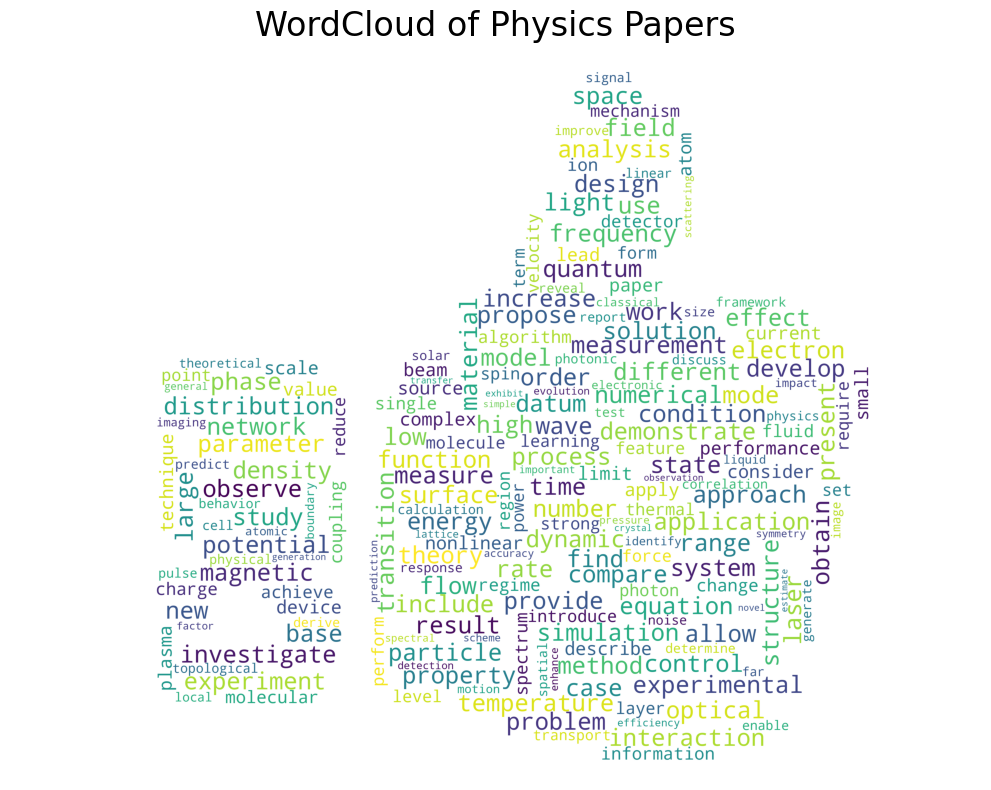

In [ ]:
#4.4 Word cloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(15.0,8.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size,
                    random_state = 42,
                    width=400,
                    height=200,
                    mask = mask)
    wordcloud.generate(" ".join(text))

    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black',
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

pos_mask = np.array(Image.open('upvote_worldcloud_project2.png'))
temp2 = pd.DataFrame(top.most_common(200))
plot_wordcloud(temp2[0].values,mask=pos_mask,color='white',max_font_size=100,title_size=24,title="WordCloud of Physics Papers")

In [ ]:
#5. Vectorization >>> convert text data into numerical data using TF-IDF matrix
#convert a collection of raw documents to TF-IDF matrix >>> transform text data into numerical data
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X
text = df['processed_text'].values
X = vectorize(text, 2 ** 12)                #arbitrary max feature --> Hyperpara. for optimisation (?)
print(X.toarray())                          #row = each abstract, column = a term >>> a term could be a single word or an n-tuple of words such as United States of America
print(X.shape)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(24008, 4096)


In [ ]:
#6. Dimensionality reduction with NMF
from sklearn.decomposition import NMF
nmf = NMF(n_components=2000, init='random', random_state=818)
X_reduced = nmf.fit_transform(X.toarray())                                   # W matrix
print('Shape of the transformed data is ',X_reduced.shape)
print('NMF reduces ',X.shape[1],' number of words to ',X_reduced.shape[1],' topics')
np.savetxt("X_reduced.csv", X_reduced, delimiter=",")

In [ ]:
#6. Dimensionality reduction with NMF
import numpy as np
import csv
with open('X_reduced_Project2.csv', 'r') as f:
    data = list(csv.reader(f))

X_reduced = np.array(data, dtype=float)
print(X_reduced)
print(X_reduced.shape)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  2.25714822e-04 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.39580686e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [8.29908047e-01 4.78733155e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 7.99557285e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(24008, 2000)


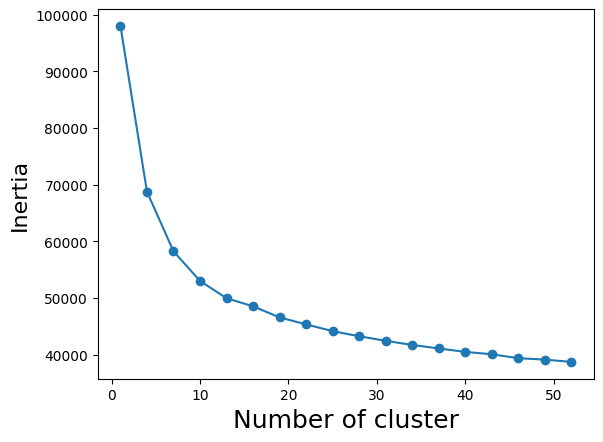

NameError: name 'y_pred' is not defined

In [ ]:
#7. Clustering using K-means
#Elbow method
from sklearn.cluster import KMeans
r_seed = 24
inertia = []
list_clusters = list(range(1,53,3))
for k in range(len(list_clusters)):
    km = KMeans(init = "k-means++", n_clusters = list_clusters[k], n_init = 12, random_state=r_seed)
    km.fit(X_reduced)
    inertia.append(km.inertia_)
import matplotlib.pyplot as plt
plt.plot(list_clusters, inertia)
plt.scatter(list_clusters,inertia)
plt.xlabel('Number of cluster', fontsize=18)
plt.ylabel('Inertia', fontsize=16)
plt.show()

#define y_pred
ll = X_reduced.shape[0]
y_pred = np.zeros((4,ll))

#K-means model
k = 16                   #optimal k found in elbow plot
k_means = KMeans(init = "k-means++", n_clusters = k, n_init = 12, random_state=r_seed)
y_pred[0] = k_means.fit_predict(X_reduced)
df['kmeans'] = y_pred[1]
print(df['kmeans'])


0        1.0
1        1.0
9        2.0
13       1.0
22       1.0
        ... 
92947    1.0
92949    1.0
92951    9.0
92957    8.0
92959    1.0
Name: Hierarchical, Length: 24008, dtype: float64


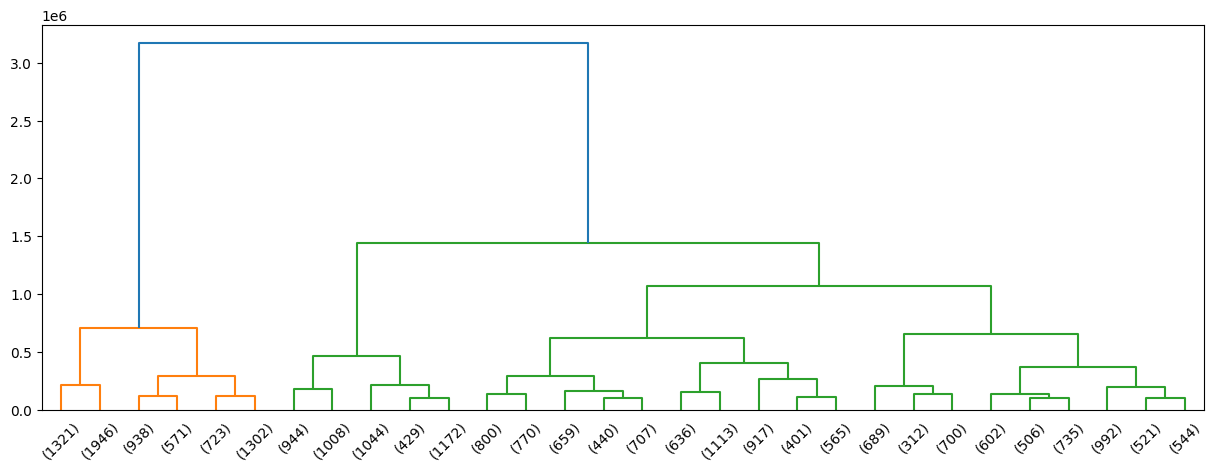

In [ ]:
#8. Clustering using Hierarchical agglomerative
from sklearn.cluster import AgglomerativeClustering
k = 16                    #optimal k from K-means
agg = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='ward', compute_full_tree=True)
y_pred[1] = agg.fit_predict(X_reduced)
df['Hierarchical'] = y_pred[1]
print(df['Hierarchical'])

#plot of the dendrogram created from agglomerative clustering
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
Z = hierarchy.linkage(agg.children_, method='ward')
fig, ax = plt.subplots(figsize=(15,5))
den = hierarchy.dendrogram(Z, orientation='top',
                           p=30, truncate_mode='lastp',
                           show_leaf_counts=True, ax=ax)


In [ ]:
#9. Clustering using Mean shift
#Standardization
#from sklearn.preprocessing import StandardScaler
#scale = StandardScaler()
#X_standard = scale.fit_transform(X_reduced)

#Mean shift
from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth = estimate_bandwidth(X_reduced)                   #estimate the value for the bandwidth parameter
ms = MeanShift(bandwidth=bandwidth , bin_seeding=True)      #bin_seeding=if true, initial kernel locations are not locations of all points, but rather the location of the discretized version of points.
y_pred[2] = ms.fit_predict(X_reduced)
df['MeanShift'] = y_pred[2]
print('Number of Clusters: ',np.unique(ms.labels_))
print(df['MeanShift'])


Number of Clusters:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66]
0        0.0
1        0.0
9        0.0
13       0.0
22       0.0
        ... 
92947    0.0
92949    0.0
92951    0.0
92957    0.0
92959    0.0
Name: MeanShift, Length: 24008, dtype: float64


In [ ]:
#10. Clustering using DBSCAN
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=2.2, min_samples=2)
y_pred[3] = db.fit_predict(X_reduced)
#df['DBSCAN'] = y_pred[3]
print('Number of Clusters: ',len(set(db.labels_) - {-1}))
print(f'Percentage of noise: {100 * (db.labels_ == -1).sum() / len(db.labels_)}%')
print(y_pred[3])
#How to choose eps and min_sample: 1. vary eps to find desired percentage of noise, 2. vary min_sample to find desired number of cluster

Number of Clusters:  9
Percentage of noise: 0.3665444851716095%
[0. 0. 0. ... 0. 0. 0.]


In [ ]:
#Save y_pred and import
#np.savetxt("y_pred_Project2.csv", y_pred, delimiter=",")

import numpy as np
import csv
with open('y_pred_Project2.csv', 'r') as f:
    data = list(csv.reader(f))

y_pred = np.array(data, dtype=float)
print(y_pred)

[[ 3.  3. 10. ...  1.  8.  3.]
 [ 1.  1.  2. ...  9.  8.  1.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 24008 samples in 0.043s...
[t-SNE] Computed neighbors for 24008 samples in 90.029s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24008
[t-SNE] Computed conditional probabilities for sample 2000 / 24008
[t-SNE] Computed conditional probabilities for sample 3000 / 24008
[t-SNE] Computed conditional probabilities for sample 4000 / 24008
[t-SNE] Computed conditional probabilities for sample 5000 / 24008
[t-SNE] Computed conditional probabilities for sample 6000 / 24008
[t-SNE] Computed conditional probabilities for sample 7000 / 24008
[t-SNE] Computed conditional probabilities for sample 8000 / 24008
[t-SNE] Computed conditional probabilities for sample 9000 / 24008
[t-SNE] Computed conditional probabilities for sample 10000 / 24008
[t-SNE] Computed conditional probabilities for sample 11000 / 24008
[t-SNE] Computed conditional probabilities for sample 12000 / 24008
[t-SNE] Computed conditional probabilities for s

<ipython-input-31-8f42bc87e68b>:26: UserWarning: The palette list has more values (20) than needed (16), which may not be intended.
  sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y_pred[i-1], legend='full', palette=palette)
<ipython-input-31-8f42bc87e68b>:26: UserWarning: The palette list has more values (20) than needed (16), which may not be intended.
  sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y_pred[i-1], legend='full', palette=palette)
<ipython-input-31-8f42bc87e68b>:26: UserWarning: 
The palette list has fewer values (20) than needed (67) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y_pred[i-1], legend='full', palette=palette)
<ipython-input-31-8f42bc87e68b>:26: UserWarning: The palette list has more values (20) than needed (10), which may not be intended.
  sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y_pred[i-1], legend='full', palette=palette)


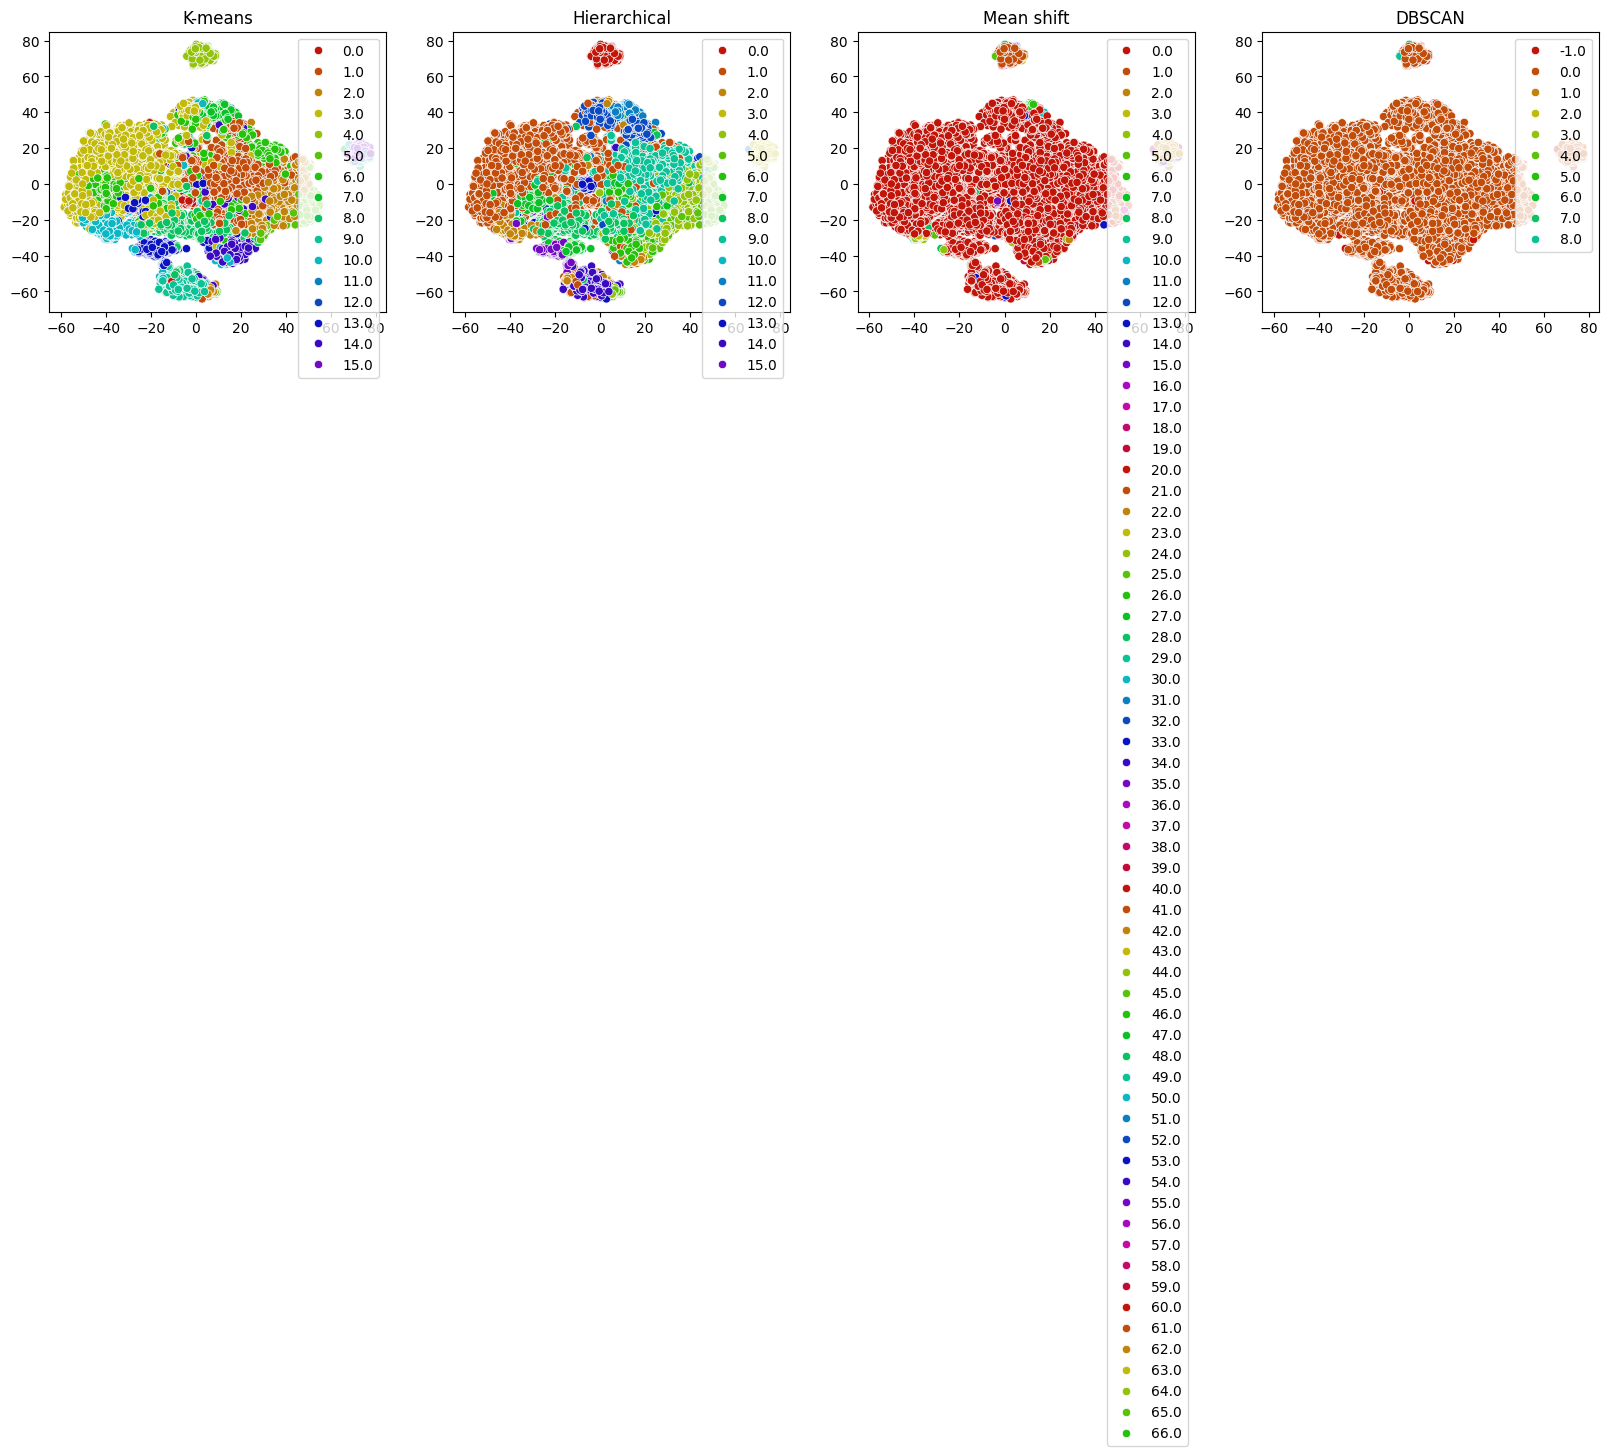

In [ ]:
#11. Visualization using t-SNE

'''
t-SNE (T-distributed Stochastic Neighbor Embedding)
- to visualize high-dimensional data
- converts similarities between data points to joint probabilities
- tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.
- t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results
- It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50)
- suffers with large datasets >>> if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples.

'''
#t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X_reduced)
print(X_embedded)

#plot
import seaborn as sns
plt.figure(figsize=(20,8))
palette = sns.hls_palette(20, l=.4, s=.9)    # colors
clusters = ['K-means','Hierarchical','Mean shift','DBSCAN']
for i in range(1,5):
    plt.subplot(2,4,i)
    sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y_pred[i-1], legend='full', palette=palette)
    plt.title(clusters[i-1])
#plt.title('T-distributed Stochastic Neighbor Embedding (t-SNE)')
#plt.savefig("cluster_tsne.png")
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[[ 4.2387147  -6.090963  ]
 [ 4.485924   -5.9440174 ]
 [ 3.030709   -1.6532165 ]
 ...
 [-2.5950902  -1.264917  ]
 [ 5.149727   -0.95201474]
 [ 2.9841938  -7.037678  ]]


<ipython-input-32-d1591ece02a3>:29: UserWarning: The palette list has more values (20) than needed (16), which may not be intended.
  sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=y_pred[i-1], legend='full', palette=palette)
<ipython-input-32-d1591ece02a3>:29: UserWarning: The palette list has more values (20) than needed (16), which may not be intended.
  sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=y_pred[i-1], legend='full', palette=palette)
<ipython-input-32-d1591ece02a3>:29: UserWarning: 
The palette list has fewer values (20) than needed (67) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=y_pred[i-1], legend='full', palette=palette)
<ipython-input-32-d1591ece02a3>:29: UserWarning: The palette list has more values (20) than needed (10), which may not be intended.
  sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=y_pred[i-1], legend='full', palette=palette)


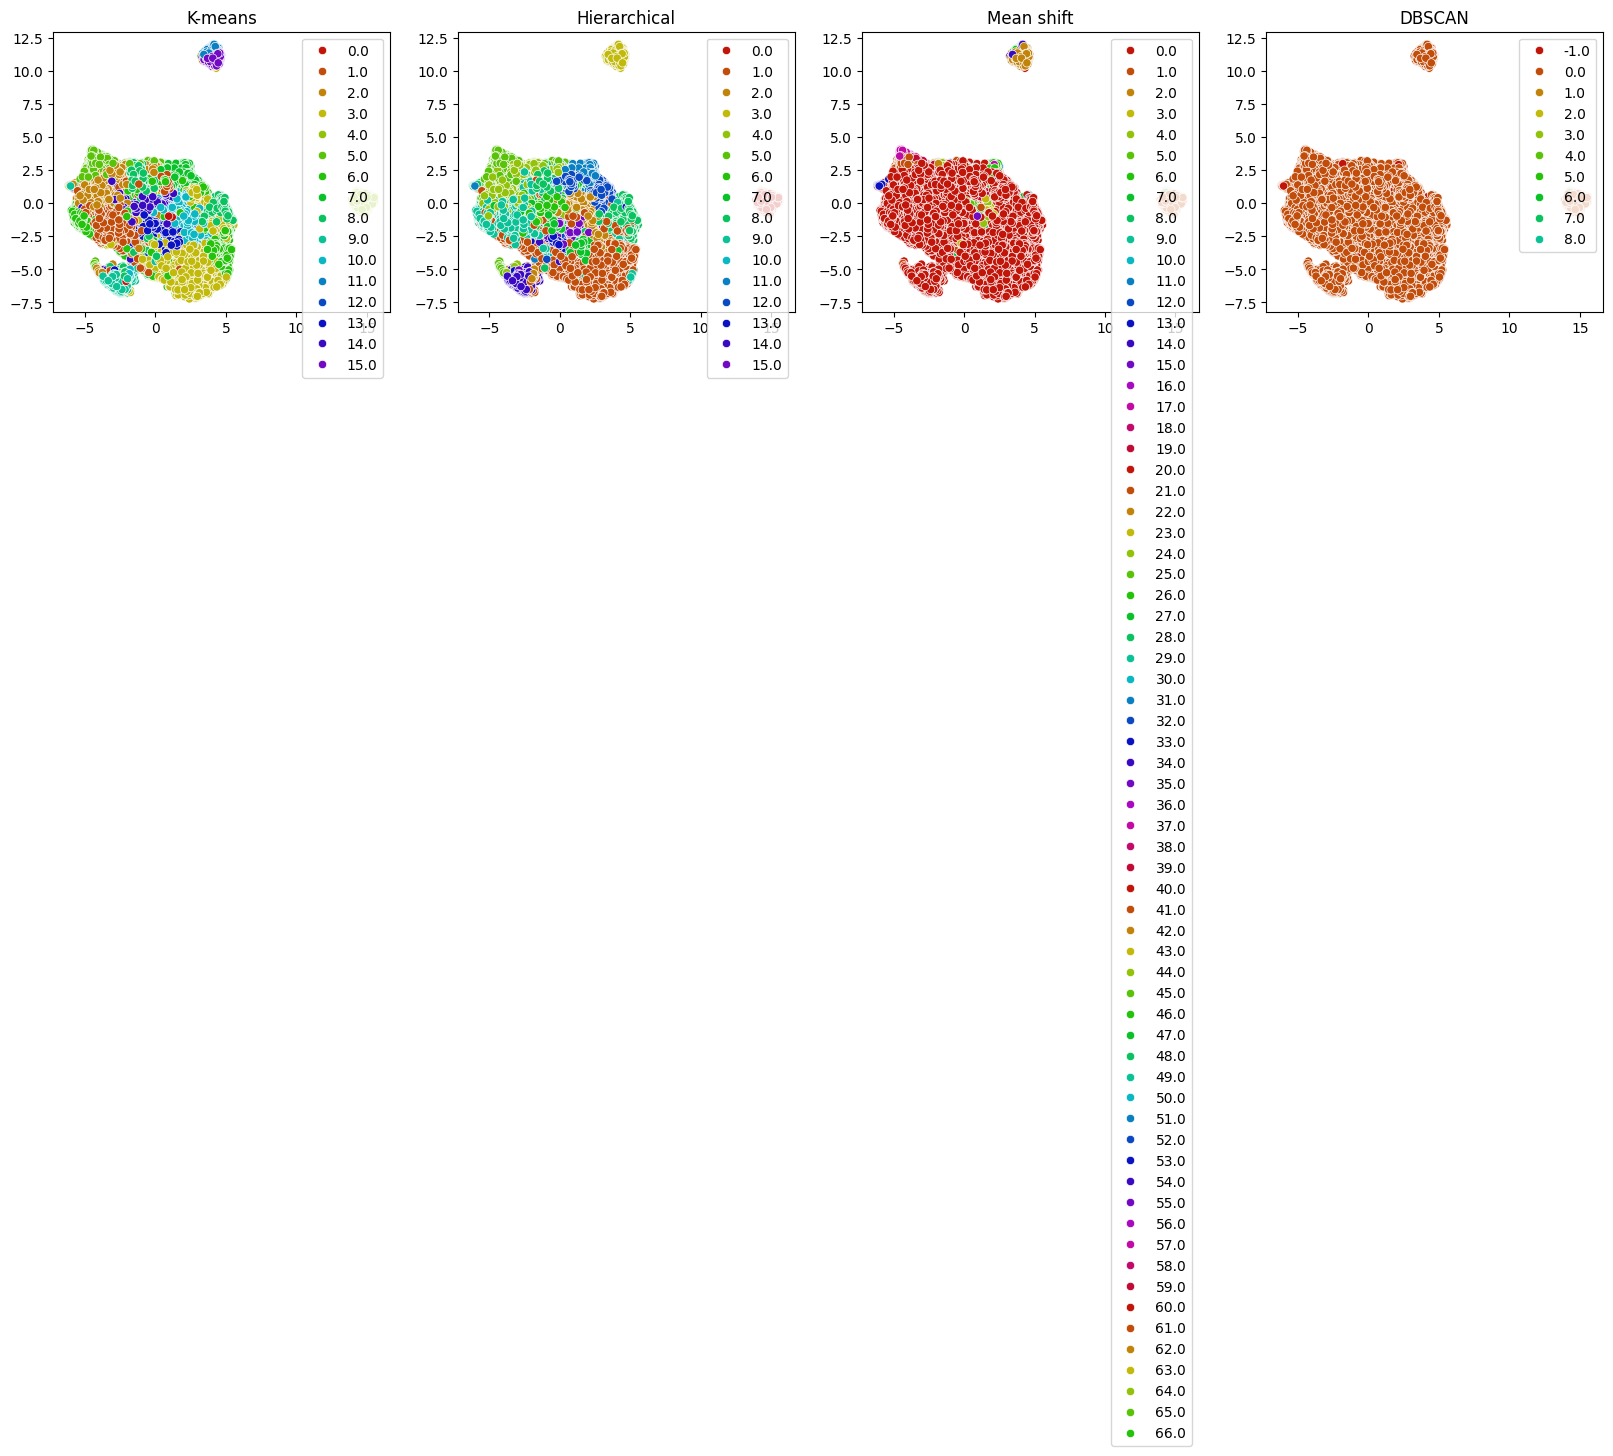

In [ ]:
#12. Visualization using UMAP

'''
UMAP (Uniform Manifold Approximation and Projection)
- constructs a high dimensional graph representation ("fuzzy simplicial complex") of the data then optimizes a low-dimensional graph to be as structurally similar as possible
- "fuzzy simplicial complex" = a representation of a weighted graph, with edge weights representing the likelihood that two points are connected
- Process: - extends a radius outwards from each point, connecting points when those radii overlap >>> choosing a radius locally, based on the distance to each point's nth nearest neighbor
           - makes the graph "fuzzy" by decreasing the likelihood of connection as the radius grows.
           - by stipulating that each point must be connected to at least its closest neighbor, UMAP ensures that local structure is preserved in balance with global structure.
           - Once the high-dimensional graph is constructed, UMAP optimizes the layout of a low-dimensional analogue to be as similar as possible. >>> same as in t-SNE
- Pros: - increase speed
        - better preservation of the data's global structure compared to t-SNE

'''
#UMAP
!pip install umap-learn
from umap import UMAP
umap_embeddings = UMAP(n_neighbors=100, min_dist=0.3, n_components=2)
X_umap = umap_embeddings.fit_transform(X_reduced)
print(X_umap)

#plot
import seaborn as sns
plt.figure(figsize=(20,8))
palette = sns.hls_palette(20, l=.4, s=.9)    # colors
clusters = ['K-means','Hierarchical','Mean shift','DBSCAN']
for i in range(1,5):
    plt.subplot(2,4,i)
    sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=y_pred[i-1], legend='full', palette=palette)
    plt.title(clusters[i-1])
#plt.title('Uniform Manifold Approximation and Projection (UMAP)')
#plt.savefig("cluster_tsne.png")
plt.show()
